# FFPP Deepfake Detection Pipeline (80:20 → 7:1 → 5-Fold → Test)

이 노트북은 “alltype” 폴더 구조를 사용하는 FaceForensics++ 데이터셋을 기반으로,  
아래 절차를 순차적으로 수행합니다:

1. **데이터 로드 및 전처리 확인**  
   - `configs/ffpp_c23.yaml`을 기준으로 데이터 경로(`dataset_root/version/alltype`) 설정  
   - `FFPPFrameDataset`을 사용해 모든 프레임 이미지와 레이블(Real/Fake) 로드  
   - 전처리 파이프라인(`get_ffpp_transforms`)이 정상 작동하는지 샘플 이미지 시각화

2. **Train/Val/Test 분할 및 5-Fold Cross-Validation 학습**  
   - 전체(alltype) 데이터 → 80% Train+Val / 20% Test 분할 (stratify)  
   - Train+Val(80%) → Train(70%) / Val(10%) 분할  
   - Train(70%) → 5-Fold Cross-Validation (Train:Val = 4:1)  
   - 각 Fold마다 학습 및 검증 수행 → Fold별 “best.pth” 저장

3. **Test(20%) 성능 평가**  
   - 마지막(5번째) Fold의 “best.pth” 모델을 불러와 Test 데이터셋에 대해 AUC/EER 계산

4. **단일 비디오 추론 (Inference)**  
   - Test 평가 이후, 새로운 비디오 파일을 “영상 → 프레임”으로 분할  
   - 각 프레임별 Deepfake 확률 예측 → JSON으로 저장  
   - (선택) 상위 확률 프레임 5개 시각화

---

**사전 준비**  
1. `deepfake_adapter_ffpp/` 디렉터리 구조가 다음과 같아야 합니다:
    ```
    deepfake_adapter_ffpp/
    ├── configs/
    │   ├── ffpp_c23.yaml
    │   └── ffpp_c40.yaml
    ├── data/
    │   └── README.md
    ├── notebooks/
    │   └── 01_pipeline.ipynb
    ├── src/
    │   ├── datasets/ffpp_dataset.py
    │   ├── models/
    │   │   ├── backbone.py
    │   │   ├── adapters.py
    │   │   └── deepfake_adapter.py
    │   ├── utils/
    │   │   ├── transforms.py
    │   │   └── metrics.py
    │   └── scripts/
    │       ├── train.py
    │       └── predict.py
    ├── outputs/
    │   ├── checkpoints/
    │   └── logs/
    ├── requirements.txt
    └── README.md
    ```
2. `configs/ffpp_c23.yaml`의 `dataset_root` 경로를 본인 환경에 맞게 수정하세요.  
   예: `"dataset_root": "D:/Files/data/FaceForensicspp_RECCE"`  
3. 필요한 라이브러리를 설치합니다:  
   ```bash
   pip install -r requirements.txt


- `configs/ffpp_c23.yaml`의 `dataset_root` 경로를 본인 환경에 맞게 수정하세요.  
- 필요한 라이브러리(`torch`, `timm`, `yaml`, `opencv-python`, `torchvision`, `sklearn` 등)를 설치합니다:  
```bash
pip install -r requirements.txt


In [3]:
# 셀 2: 라이브러리 임포트 및 설정 불러오기

import os
import yaml
import random
import json
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# src/ 경로를 import 경로에 추가
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# 사용자 정의 모듈
from src.datasets.ffpp_dataset import FFPPFrameDataset
from src.models.deepfake_adapter import DeepfakeAdapter
from src.utils.transforms import get_ffpp_transforms
from src.utils.metrics import compute_auc, compute_eer

# --- 설정(Config) 로드 ---
config_path = "../configs/ffpp_c23.yaml"  # 노트북이 notebooks/ 폴더 안에 있으므로 상위 폴더 참조
with open(config_path, "r") as f:
    cfg = yaml.safe_load(f)

# 재현성(Seed) 고정 함수
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# 디바이스 설정 (GPU 사용 우선)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print("Config:", cfg)


Device: cuda
Config: {'dataset_root': 'D:/My Project/Deepfake/df_train/data/FaceForensicspp_RECCE', 'version': 'c23_frames', 'input_size': 224, 'batch_size': 32, 'num_workers': 4, 'model': {'backbone': 'vit_base_patch16_224', 'adapter_dim': 128, 'num_classes': 2}, 'optimizer': {'type': 'adamw', 'lr': '1e-4', 'weight_decay': '1e-5'}, 'scheduler': {'type': 'cosine', 'T_max': 50}, 'training': {'epochs': 50, 'k_folds': 5}, 'output_dir': 'outputs/checkpoints/ffpp_c23', 'log_dir': 'outputs/logs/ffpp_c23'}


## 데이터셋 로드 및 전처리 확인

- `FFPPFrameDataset`을 이용해 **alltype** 데이터 전체를 로드합니다.
- `get_ffpp_transforms(cfg["input_size"])`으로 이미지가 Resize → ToTensor → Normalize 되는지 확인합니다.
- 샘플 이미지를 시각화하여 전처리 결과를 눈으로 확인해 봅니다.


Total samples (alltype): 2145914
Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])


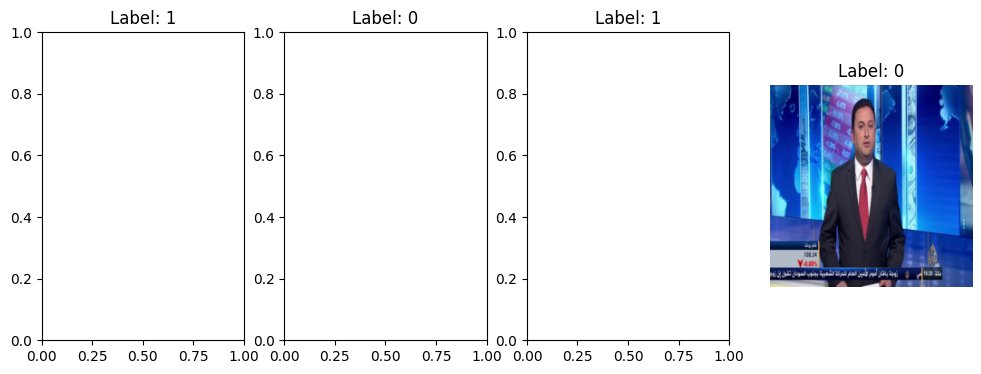

In [4]:
# 셀 3: 데이터셋 로드 및 전처리 확인

set_seed(42)

# 1) 전체 데이터셋 로드 (alltype)
full_dataset = FFPPFrameDataset(config_path)
print(f"Total samples (alltype): {len(full_dataset)}")

# 2) 임시 DataLoader 구성 — 배치 형태 확인용
temp_loader = DataLoader(
    full_dataset,
    batch_size=cfg["batch_size"],
    shuffle=True,
    num_workers=cfg["num_workers"],
    pin_memory=True
)

# 3) 첫 번째 배치 가져와서 이미지 텐서 모양 확인
images, labels = next(iter(temp_loader))
print("Batch images shape:", images.shape)  # [batch_size, 3, input_size, input_size]
print("Batch labels shape:", labels.shape)  # [batch_size]

# 4) 샘플 이미지 시각화 (정규화 해제 후 표시)
def imshow_tensor(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """정규화된 텐서를 이미지로 되돌려 Matplotlib으로 표시"""
    img = img_tensor.clone().cpu().numpy()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0))  # (H, W, C)
    plt.imshow(img)
    plt.axis("off")

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    imshow_tensor(images[i])
    axes[i].set_title(f"Label: {labels[i].item()}")
plt.show()


## Train/Val/Test 분할 (80:20 → 7:1) + 5-Fold 학습/검증 + Test 평가

1. 전체(alltype) 데이터 → Train+Val(80%) / Test(20%) 분할 (stratify)
2. Train+Val(80%) → Train(70%) / Val(10%) 분할 (stratify)
3. Train(70%)에 대해 **5-Fold Cross-Validation** 수행
   - 각 Fold마다 Train/Val 로더 구성 → 학습 및 검증 → Fold별 최적 모델 저장
4. 마지막(5번째) Fold의 모델을 불러와 Test(20%) 평가 (AUC/EER)


In [5]:
# 셀 4: Train/Val/Test 분할 + 5-Fold 학습/검증 + Test 평가 (tqdm 적용 버전)

from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import Subset
from tqdm import tqdm           # 일반 텍스트 기반 tqdm 사용


set_seed(42)

# (1) 전체 데이터셋 로드
full_dataset = FFPPFrameDataset(config_path)
N = len(full_dataset)
print(f"Total samples (alltype): {N}")

# (2) 전체 → Train+Val(80%) / Test(20%) 분할 (stratify 유지)
all_indices = list(range(N))
all_labels  = list(full_dataset.labels)

trainval_idx, test_idx = train_test_split(
    all_indices,
    test_size=0.2,
    random_state=42,
    stratify=all_labels
)
print(f"Train+Val count: {len(trainval_idx)}, Test count: {len(test_idx)}")

# (3) Train+Val(80%) → Train(70%) / Val(10%) 분할
train_idx, val_idx = train_test_split(
    trainval_idx,
    test_size=0.125,
    random_state=42,
    stratify=[all_labels[i] for i in trainval_idx]
)
print(f"Train count: {len(train_idx)}, Val count: {len(val_idx)}, Test count: {len(test_idx)}")

# (4) Train(70%)에 대해 K-Fold(5-Fold) 수행
k_folds = cfg["training"].get("k_folds", 5)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (tr_sub, va_sub) in enumerate(kfold.split(train_idx)):
    print(f"\n--- Fold {fold+1}/{k_folds} ---")
    true_train_idx = [train_idx[i] for i in tr_sub]
    true_val_idx   = [train_idx[i] for i in va_sub]

    train_subset = Subset(full_dataset, true_train_idx)
    val_subset   = Subset(full_dataset, true_val_idx)

    train_loader = DataLoader(
        train_subset,
        batch_size=cfg["batch_size"],
        shuffle=True,
        num_workers=cfg["num_workers"],
        pin_memory=True
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=cfg["batch_size"],
        shuffle=False,
        num_workers=cfg["num_workers"],
        pin_memory=True
    )

    # (A) 모델, 손실함수, 옵티마이저, 스케줄러 설정
    model = DeepfakeAdapter(cfg).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=float(cfg["optimizer"]["lr"]),
        weight_decay=float(cfg["optimizer"]["weight_decay"])
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=int(cfg["scheduler"]["T_max"])
    )

    # (B) Fold별 체크포인트/로그 디렉터리
    fold_ckpt_dir = os.path.join(cfg["output_dir"], f"fold_{fold+1}")
    fold_log_dir  = os.path.join(cfg["log_dir"],  f"fold_{fold+1}")
    os.makedirs(fold_ckpt_dir, exist_ok=True)
    os.makedirs(fold_log_dir, exist_ok=True)

    writer = SummaryWriter(log_dir=fold_log_dir)
    best_auc = 0.0

    # (C) Epoch별 학습 + 검증 루프
    for epoch in range(cfg["training"]["epochs"]):
        #########################
        # (C-1) Training 단계 (tqdm 적용)
        #########################
        model.train()
        running_loss = 0.0

        # train_loader 전체를 tqdm으로 감싸서 진행률 표시
        for images, labels in tqdm(train_loader, desc=f"Fold {fold+1} Train Epoch {epoch+1}", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        scheduler.step()
        avg_train_loss = running_loss / len(train_loader.dataset)
        writer.add_scalar("Loss/train", avg_train_loss, epoch)

        #########################
        # (C-2) Validation 단계 (tqdm 적용)
        #########################
        model.eval()
        all_labels_fold = []
        all_scores_fold = []
        # tqdm으로 감싼 val_loader
        for images, labels in tqdm(val_loader, desc=f"Fold {fold+1} Val Epoch {epoch+1}", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            probs = torch.softmax(logits, dim=1)[:, 1]  # fake 확률
            all_labels_fold.extend(labels.cpu().numpy())
            all_scores_fold.extend(probs.cpu().numpy())

        val_auc = compute_auc(np.array(all_labels_fold), np.array(all_scores_fold))
        val_eer = compute_eer(np.array(all_labels_fold), np.array(all_scores_fold))
        writer.add_scalar("AUC/val", val_auc, epoch)
        writer.add_scalar("EER/val", val_eer, epoch)

        print(
            f"[Fold {fold+1}/{k_folds} | Epoch {epoch+1}/{cfg['training']['epochs']}] "
            f"Train Loss: {avg_train_loss:.4f}  Val AUC: {val_auc:.4f}  Val EER: {val_eer:.4f}"
        )

        #########################
        # (C-3) 최적 모델 저장
        #########################
        if val_auc > best_auc:
            best_auc = val_auc
            ckpt = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "auc": val_auc,
            }
            save_path = os.path.join(fold_ckpt_dir, "best.pth")
            torch.save(ckpt, save_path)
            print(f"→ New best model for Fold {fold+1} saved at {save_path}")

    writer.close()

# (5) 5-Fold 완료 후 Test 셋 평가
print("\n=== K-Fold Training Complete ===")
print("Evaluating on the Test set using Fold 5's best model...")

test_subset = Subset(full_dataset, test_idx)
test_loader  = DataLoader(
    test_subset,
    batch_size=cfg["batch_size"],
    shuffle=False,
    num_workers=cfg["num_workers"],
    pin_memory=True
)
print(f"Test samples: {len(test_subset)}")

last_ckpt_path = os.path.join(cfg["output_dir"], f"fold_{k_folds}", "best.pth")
assert os.path.exists(last_ckpt_path), f"Checkpoint not found: {last_ckpt_path}"

model = DeepfakeAdapter(cfg).to(device)
ckpt = torch.load(last_ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

all_test_labels = []
all_test_scores = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Test Evaluation", leave=False):
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        probs = torch.softmax(logits, dim=1)[:, 1]  # fake 확률

        all_test_labels.extend(labels.cpu().numpy())
        all_test_scores.extend(probs.cpu().numpy())

test_auc = compute_auc(np.array(all_test_labels), np.array(all_test_scores))
test_eer = compute_eer(np.array(all_test_labels), np.array(all_test_scores))
print(f"Final Test AUC: {test_auc:.4f}, Test EER: {test_eer:.4f}")


Total samples (alltype): 2145914
Train+Val count: 1716731, Test count: 429183
Train count: 1502139, Val count: 214592, Test count: 429183

--- Fold 1/5 ---


KeyboardInterrupt: 

## 추론(Inference)

- 학습된 Fold 5 모델(`fold_5/best.pth`)을 사용하여 **단일 비디오**에 대해 Deepfake 확률을 예측하고,  
  결과를 프레임 단위 JSON 파일(`outputs/predictions/[video_name].json`)로 저장합니다.
- 과정:
  1. `cv2.VideoCapture`로 비디오를 열어 `temp_frames_infer/` 폴더에 프레임 저장  
  2. 저장된 프레임에 대해 `get_ffpp_transforms(cfg["input_size"])` 적용 후 모델 예측  
  3. 각 프레임별 fake 확률을 JSON으로 저장


In [ ]:
# 셀 5: 추론(Inference)

# (A) 추론할 비디오 파일 경로 지정 (본인이 테스트할 비디오 경로로 수정)
test_video_path = "../data/raw_videos/sample_video.mp4"  # 예시
assert os.path.exists(test_video_path), f"Video not found: {test_video_path}"

# (B) 임시 폴더에 프레임 추출
temp_frames_dir = "temp_frames_infer"
if os.path.exists(temp_frames_dir):
    for f in os.listdir(temp_frames_dir):
        os.remove(os.path.join(temp_frames_dir, f))
else:
    os.makedirs(temp_frames_dir)

cap = cv2.VideoCapture(test_video_path)
frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    save_path = os.path.join(temp_frames_dir, f"frame_{frame_idx:06d}.jpg")
    cv2.imwrite(save_path, frame)
    frame_idx += 1
cap.release()
print(f"Extracted {frame_idx} frames to '{temp_frames_dir}'")

# (C) TempFrameDataset 정의 및 DataLoader 구성
transform = get_ffpp_transforms(cfg["input_size"])
frame_paths = sorted([
    os.path.join(temp_frames_dir, fn)
    for fn in os.listdir(temp_frames_dir)
    if fn.endswith(".jpg") or fn.endswith(".png")
])

class TempFrameDataset(torch.utils.data.Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img), self.paths[idx]

temp_dataset = TempFrameDataset(frame_paths, transform)
temp_loader = DataLoader(
    temp_dataset,
    batch_size=cfg["batch_size"],
    shuffle=False,
    num_workers=cfg["num_workers"],
    pin_memory=True
)

# (D) 마지막 Fold 모델 로드
best_ckpt_path = os.path.join(cfg["output_dir"], f"fold_{cfg['training']['k_folds']}", "best.pth")
assert os.path.exists(best_ckpt_path), f"Checkpoint not found: {best_ckpt_path}"

model = DeepfakeAdapter(cfg).to(device)
ckpt = torch.load(best_ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

# (E) 프레임 단위 예측
results = {}  # { "frame_path": fake_probability }
with torch.no_grad():
    for imgs, paths in temp_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # fake 확률
        for p, prob in zip(paths, probs):
            results[p] = float(prob)

# (F) JSON으로 저장
video_name = os.path.splitext(os.path.basename(test_video_path))[0]
output_json_dir = "outputs/predictions"
os.makedirs(output_json_dir, exist_ok=True)
output_json_path = os.path.join(output_json_dir, f"{video_name}.json")

with open(output_json_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Saved prediction results to '{output_json_path}'")


## 결과 시각화 예시

- **추출된 프레임 중 상위 5개**를 선택하여,  
  프레임 원본 이미지 + 예측된 “Fake 확률”을 함께 시각화해 봅니다.
- JSON 파일에서 상위 5개 확률 프레임을 골라서 확인합니다.


In [ ]:
# 셀 6: 결과 시각화 예시

with open(output_json_path, "r") as f:
    results_json = json.load(f)

# 프레임별 확률 내림차순 정렬 → 상위 5개
sorted_items = sorted(results_json.items(), key=lambda x: x[1], reverse=True)
top5 = sorted_items[:5]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, (frame_path, prob) in enumerate(top5):
    img = Image.open(frame_path).convert("RGB")
    axes[i].imshow(np.array(img))
    axes[i].set_title(f"{os.path.basename(frame_path)}\nFake: {prob:.3f}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()


## 마무리 및 토의

1. **데이터 로드 및 전처리 확인**  
   - `FFPPFrameDataset`을 통해 **alltype** 폴더 구조에서 모든 프레임과 Real/Fake 레이블을 올바르게 로드했음을 확인했습니다.

2. **Train(70%) / Val(10%) / Test(20%) 분할**  
   - 전체 데이터를 80:20으로 분할한 뒤, Train(80%) 내부를 다시 7:1로 분할하여 **Train 70%, Val 10%, Test 20%** 비율을 만들었습니다.

3. **5-Fold Cross-Validation 학습 + 검증**  
   - `KFold(n_splits=5, shuffle=True, random_state=42)`로 Train(70%)을 5개 Fold로 나누어,  
   - 각 Fold마다 학습 및 검증을 수행하고 **Fold별 최적 모델(best.pth)** 을 저장했습니다.

4. **Test(20%) 최종 평가**  
   - 마지막(5번째) Fold의 최적 모델을 불러와 Test(20%) 데이터셋에 대해 **AUC/EER**을 계산했습니다.

5. **추론(Inference)**  
   - 새로운 비디오 파일을 “영상 → 프레임”으로 분할한 뒤,  
   - 마지막 Fold 모델로 프레임별 Deepfake 확률을 예측하여 JSON(`outputs/predictions/[video_name].json`)으로 저장했습니다.

6. **결과 시각화**  
   - 상위 5개 “Fake 확률이 높은 프레임”을 시각화하여,  
     모델이 어느 순간 가장 Fake이라고 판단했는지 직관적으로 확인했습니다.

---

### 향후 방향

- **하이퍼파라미터 튜닝**  
  - `training.k_folds`, `optimizer.lr`, `scheduler.T_max`, `model.adapter_dim` 등을 변경하며 성능 최적화  
  - 5-Fold 학습 결과를 앙상블(Ensembling)하여 Test 성능 향상 시도 가능

- **Transformer-XAI**  
  - 현재는 ViT + Dual-Level Adapter 기반 분류기까지만 구현되어 있습니다.  
  - 이후 “Attention Map”, “Token Attribution” 등 Transformer 설명 기법을 추가하여,  
    모델의 의사결정 근거를 시각화할 예정입니다.

- **배포 및 서비스**  
  학습된 모델(`fold_i/best.pth`)을 REST API 또는 Streamlit 앱으로 배포하여,  
  사용자가 업로드한 동영상에 대해 실시간으로 Deepfake 여부를 확인할 수 있도록 서비스화할 수 있습니다.

---

이 노트북이 FFPP 기반 DeepFake Detection 전체 파이프라인을 이해하고, 직접 실험해보는 데 도움이 되길 바랍니다. 감사합니다!
